<span style="font-size: 30px; font-weight: bold;">Data Wrangling Overview </span>

<span style="font-size: 16px; font-weight: bold;">Description from Kaggel competition: </span>

M5 Forecasting - Accuracy 
In the challenge, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy. This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE).
Predicting unit sales for days 1914-1941

## Table of Contents

- [Load Datasets](#load-datasets)
- [Review Sales Data](#review-sales-data)
- [Review Price Data](#review-price-data)
- [Review Calendar Data](#review-calendar-data)
- [Changing sales_df to Panel View](#changing-sales-df-to-panel-view)
- [Joining Sales, Calendar, and Price Dataframes](#joining-sales-calendar-and-price-dataframes)
- [Fixing NaN's on sell_price](#fixing-nans-on-sell-price)
- [Final Adjustments to sales_df and Saving](#final-adjustments-to-sales-df-and-saving)
- [Data Wrangling Summary](#summary)


In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import os
from pathlib import Path

<span id="load-datasets" style="font-size: 30px; font-weight: bold;">Load Datasets</span>

In [2]:
calendar_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\calendar.csv")
price_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\sell_prices.csv")
sales_df = pd.read_csv(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Data\sales_train_validation.csv")

<span id="review-sales-data" style="font-size: 16px; font-weight: bold;">Review Sales Data</span>

In [3]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
sales_df['id'].nunique()

30490

In [5]:
sales_df['item_id'].nunique()

3049

In [6]:
sales_df['state_id'].nunique()

3

In [7]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [8]:
unique_store_ids = sales_df['store_id'].unique()
count_unique_store_ids = sales_df['store_id'].nunique()

print("Unique store_ids:", unique_store_ids)
print("Count of unique store_ids:", count_unique_store_ids)

Unique store_ids: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Count of unique store_ids: 10


In [9]:
unique_cat_ids = sales_df['cat_id'].unique()
count_unique_cat_ids = sales_df['cat_id'].nunique()

print("Unique cat_ids:", unique_cat_ids)
print("Count of unique cat_ids:", count_unique_cat_ids)

Unique cat_ids: ['HOBBIES' 'HOUSEHOLD' 'FOODS']
Count of unique cat_ids: 3


In [10]:
unique_dept_ids = sales_df['dept_id'].unique()
count_unique_dept_ids = sales_df['dept_id'].nunique()

print("Unique dept_ids:", unique_dept_ids)
print("Count of unique dept_ids:", count_unique_dept_ids)

Unique dept_ids: ['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
Count of unique dept_ids: 7


In [11]:
unique_item_ids = sales_df['item_id'].unique()
count_unique_item_ids = sales_df['item_id'].nunique()

print("Unique item_ids:", unique_item_ids)
print("Count of unique item_ids:", count_unique_item_ids)

Unique item_ids: ['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
Count of unique item_ids: 3049


<span style="font-size: 16px;">Changing Dtypes from Object to Category </span>

In [12]:
columns_to_convert = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
sales_df[columns_to_convert] = sales_df[columns_to_convert].astype("category")

In [13]:
sales_df.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [14]:
missing_values = pd.concat([sales_df.isnull().sum(), 100 * sales_df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by='count', ascending=False, inplace=True)
missing_sort = missing_values.query('count > 0')
missing_sort.sort_values(by = 'count', ascending = False)

,count,%


<span id="review-price-data" style="font-size: 16px; font-weight: bold;">Review Price Data</span>

In [15]:
price_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [16]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


<span style="font-size: 16px;">Changing Dtypes from Object to Category </span>

In [17]:
price_df["store_id"] = price_df["store_id"].astype("category")
price_df["item_id"] = price_df["item_id"].astype("category")

In [18]:
price_df["wm_yr_wk"] = price_df["wm_yr_wk"].astype("uint16")

In [19]:
price_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [20]:
missing_values2 = pd.concat([price_df.isnull().sum(), 100 * price_df.isnull().mean()], axis=1)
missing_values2.columns = ['count', '%']
missing_values2.sort_values(by='count', ascending=False, inplace=True)
missing_sort2 = missing_values2.query('count > 0')
missing_sort2 = missing_sort2.sort_values(by='count', ascending=False).copy()

missing_sort2

,count,%


<span id="review-calendar-data" style="font-size: 16px; font-weight: bold;">Review Calendar Data</span>

In [21]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [22]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [23]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


<span style="font-size: 16px;">Changing Dtypes for improved memory efficiency and time series forecasting.</span>

In [24]:
columns_to_convert = ["d", "event_name_1", "event_type_1", "event_name_2", "event_type_2", "weekday"]
calendar_df[columns_to_convert] = calendar_df[columns_to_convert].astype("category")

In [25]:
calendar_df["snap_CA"] = calendar_df["snap_CA"].astype(np.uint8)
calendar_df["snap_TX"] = calendar_df["snap_TX"].astype(np.uint8)
calendar_df["snap_WI"] = calendar_df["snap_WI"].astype(np.uint8)

In [26]:
calendar_df["wday"] = calendar_df["wday"].astype(np.uint8)
calendar_df["month"] = calendar_df["month"].astype(np.uint8)
calendar_df["year"] = calendar_df["year"].astype(np.uint16)

In [27]:
calendar_df["wm_yr_wk"] = calendar_df["wm_yr_wk"].astype(np.uint16)

In [28]:
calendar_df["date"] = pd.to_datetime(calendar_df["date"])

In [29]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   uint16        
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   uint8         
 4   month         1969 non-null   uint8         
 5   year          1969 non-null   uint16        
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   uint8         
 12  snap_TX       1969 non-null   uint8         
 13  snap_WI       1969 non-null   uint8         
dtypes: category(6), datetime64[ns](1), uint16(2), uint8(5)
memory usage: 128.3 KB


In [30]:
missing_values3 = pd.concat([calendar_df.isnull().sum(), 100 * calendar_df.isnull().mean()], axis=1)
missing_values3.columns = ['count', '%']
missing_values3.sort_values(by='count', ascending=False, inplace=True)
missing_sort3 = missing_values3.query('count > 0')
missing_sort3 = missing_sort3.sort_values(by='count', ascending=False).copy()

missing_sort3

,count,%
event_name_2,1964,99.746064
event_type_2,1964,99.746064
event_name_1,1807,91.772473
event_type_1,1807,91.772473


<span style="font-size: 16px;">Fixing missing calendar data.  Nan event columns show an absence of promotion event.  NaN values will be imputed with a new category called “no_promo”.</span>

In [31]:
# Set "no_promo" as a category in the categorical columns
calendar_df["event_name_2"] = calendar_df["event_name_2"].cat.add_categories("no_promo")
calendar_df["event_type_2"] = calendar_df["event_type_2"].cat.add_categories("no_promo")
calendar_df["event_name_1"] = calendar_df["event_name_1"].cat.add_categories("no_promo")
calendar_df["event_type_1"] = calendar_df["event_type_1"].cat.add_categories("no_promo")

# Replace NaN values with "no_promo"
calendar_df["event_name_2"].fillna("no_promo", inplace=True)
calendar_df["event_type_2"].fillna("no_promo", inplace=True)
calendar_df["event_name_1"].fillna("no_promo", inplace=True)
calendar_df["event_type_1"].fillna("no_promo", inplace=True)

In [32]:
missing_values4 = pd.concat([calendar_df.isnull().sum(), 100 * calendar_df.isnull().mean()], axis=1)
missing_values4.columns = ['count', '%']
missing_values4.sort_values(by='count', ascending=False, inplace=True)
missing_sort3 = missing_values4.query('count > 0')
missing_sort3 = missing_sort3.sort_values(by='count', ascending=False).copy()

missing_sort3

,count,%


<span id="changing-sales-df-to-panel-view" style="font-size: 30px; font-weight: bold;">Changing sales_df to Panel View</span>

In [33]:
sales_df = sales_df.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="day",
    value_name="units_sold"
)
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [34]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   id          category
 1   item_id     category
 2   dept_id     category
 3   cat_id      category
 4   store_id    category
 5   state_id    category
 6   day         object  
 7   units_sold  int64   
dtypes: category(6), int64(1), object(1)
memory usage: 1.3+ GB


<span id="joining-sales-calendar-and-price-dataframes" style="font-size: 30px; font-weight: bold;">Joining Sales, Calendar and Price Dataframes</span>

In [35]:
# Change calendar "d" to "day" for join.
calendar_df = calendar_df.rename(columns={"d": "day"})

In [36]:
# Merging sales_df with calendar_df. Leaving out redundant columns: wday, month, and year. 
sales_df = sales_df.merge(right=calendar_df[["day", "date", "weekday", "wm_yr_wk", "event_name_1", "event_type_1", "event_name_2", "event_type_2","snap_CA", "snap_TX", "snap_WI"]], on="day",)

In [37]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0


In [38]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   day           object        
 7   units_sold    int64         
 8   date          datetime64[ns]
 9   weekday       category      
 10  wm_yr_wk      uint16        
 11  event_name_1  category      
 12  event_type_1  category      
 13  event_name_2  category      
 14  event_type_2  category      
 15  snap_CA       uint8         
 16  snap_TX       uint8         
 17  snap_WI       uint8         
dtypes: category(11), datetime64[ns](1), int64(1), object(1), uint16(1), uint8(3)
memory usage: 2.7+ GB


In [39]:
# Merging sales_df with price_df with a left join to keep all sales observations when merging with price
sales_df = sales_df.merge(price_df, on=["store_id", "item_id", "wm_yr_wk"], how='left')

In [40]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,Saturday,11101,no_promo,no_promo,no_promo,no_promo,0,0,0,NaN


In [41]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 19 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   day           object        
 7   units_sold    int64         
 8   date          datetime64[ns]
 9   weekday       category      
 10  wm_yr_wk      uint16        
 11  event_name_1  category      
 12  event_type_1  category      
 13  event_name_2  category      
 14  event_type_2  category      
 15  snap_CA       uint8         
 16  snap_TX       uint8         
 17  snap_WI       uint8         
 18  sell_price    float64       
dtypes: category(11), datetime64[ns](1), float64(1), int64(1), object(1), uint16(1), uint8(3)
memory usage: 3.2+ GB


In [42]:
unique_days = sales_df['day'].nunique()
unique_days

1913

<span id="fixing-nans-on-sell-price" style="font-size: 30px; font-weight: bold;">Fixing NaN's on sell_price  </span>

In [43]:
missing_values = pd.concat([sales_df.isnull().sum(), 100 * sales_df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by='count', ascending=False, inplace=True)
missing_sort = missing_values.query('count > 0')
missing_sort.sort_values(by = 'count', ascending = False)

,count,%
sell_price,12299413,21.086864


In [44]:
num_unique_prices = sales_df["sell_price"].nunique()
num_unique_prices

1029

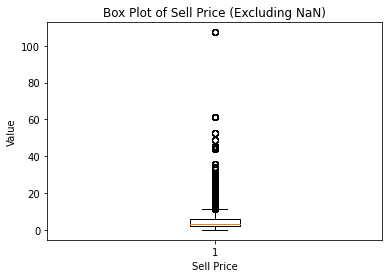

In [45]:
# Filter out NaN values from sell_price column
sell_price_filtered = sales_df["sell_price"].dropna()

# Create a box plot of filtered sell_price
plt.boxplot(sell_price_filtered)

# Set the title and labels
plt.title("Box Plot of Sell Price (Excluding NaN)")
plt.xlabel("Sell Price")
plt.ylabel("Value")

# Display the plot
plt.show()

In [46]:
sell_price_stats = sales_df["sell_price"].describe()
sell_price_stats

count    4.602796e+07
mean     4.408089e+00
std      3.403657e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64

In [47]:
# Filling NaN sell_price with 0 to represent absence of sell price
sales_df['sell_price'] = sales_df['sell_price'].fillna(0)

<span id="final-adjustments-to-sales-df-and-saving" style="font-size: 30px; font-weight: bold;">Final Adjustments to sales_df and Saving </span>

<span style="font-size: 16px;">Dropping redundant columns </span>

In [48]:
sales_df = sales_df.drop('wm_yr_wk', axis=1)

<span style="font-size: 16px;">Sorting dataset for time series </span>

In [49]:
sales_df = sales_df.sort_values(by=["id", "date"])

In [50]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,units_sold,date,weekday,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,Saturday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
32102,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,Sunday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,Monday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0
93082,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,Tuesday,no_promo,no_promo,no_promo,no_promo,1,1,0,2.0
123572,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,Wednesday,no_promo,no_promo,no_promo,no_promo,1,0,1,2.0


<span style="font-size: 16px;">Saving the clean dataset </span>

In [51]:
# Define the directory path
output_dir = Path("C:/Users/brian/Desktop/Time Series Predict Unit Sales for Walmart/Clean Dataset")

# Specify the file path for the Parquet file
output_file = output_dir / "data.parquet"

# Save sales_df as a Parquet file with partitioning
sales_df.to_parquet(
    output_file,
    index=False,
    engine="pyarrow",
    partition_cols=["store_id"]
)

<span id="summary" style="font-size: 30px; font-weight: bold;">Data Wrangling Summary </span>

<span style="font-size: 16px;">During the initial stage of data wrangling, I began by loading the sales, calendar events, and price datasets. To optimize memory usage and prepare the data for time series modeling, I performed necessary modifications to the data types. Subsequently, I conducted a thorough check for missing values within the datasets. In particular, I discovered that the calendar_df was lacking categorical information pertaining to event names and types. To address this, I introduced a new category called "no_promo" and assigned it to all the NaN values. This categorization signifies that there were no special promotions listed for those specific days.</span>

<span style="font-size: 16px;">My focus moved on to merging the three datasets into one dataset called sales_df. The process involved several steps. Firstly, I transformed the original sales_df into a panel view, consolidating the columns representing different days into a single column containing observations from d_1 to d_1913. Next, I performed a right join between the sales data and the calendar_df using their shared "day" column. Lastly, I carried out a left join to merge the price dataframe with sales_df. This merge ensured that all observations from the sales data were retained while incorporating the corresponding sell prices from the price dataframe. As a result, the final dataset, sales_df, was obtained.</span>

<span style="font-size: 16px;">I made several final adjustments to the consolidated sales_df dataset. First, I replaced any NaN values in the sell_price column with zeros. Then, I removed redundant columns to streamline the dataset. To establish a time series, I sorted the dataset by "id" and "date". However, when attempting to save the file as a .csv, I encountered difficulties. As a solution, I familiarized myself with using a parquet file format and saved the dataset with partitions based on the store_id.</span>

<span style="font-size: 16px;">In conclusion the sales_df is a merged dataset containing sales, calendar, and promotion information and is prepared for further exploratory data analysis for time series modeling.</span>